In [1]:
import sys

import matplotlib.pyplot as plt
import torch
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

from src.common.paths import PlotPaths
from src.models.vae.vae import VariationalAutoEncoder
from src.plotting.city_emission_field_plot import plot_emission_field_tensor, scale_emission_field_tensor_for_plotting

In [2]:
MODEL_NAME = "2048"

vae = VariationalAutoEncoder.load(model_name=MODEL_NAME)

animations_path = PlotPaths.ANIMATIONS / "latent_space_walk"
animations_path.mkdir(exist_ok=True)

animation_path = animations_path/ f"{MODEL_NAME}.gif"

In [3]:
num_steps = 100

start_point = torch.randn(vae.latent_dimension)
end_point = torch.randn(vae.latent_dimension)

# Generate random control points for the Bézier curve
control_points = [torch.randn(vae.latent_dimension) for _ in range(2)]  # Adjust the number as needed

# Bézier curve interpolation
def bezier(t, points):
    """Compute a point on a Bézier curve given parameter t and control points."""
    n = len(points) - 1
    return sum(
        comb(n, i) * (1 - t)**(n - i) * t**i * points[i] for i in range(n + 1)
    )

from scipy.special import comb
t_values = torch.linspace(0, 1, num_steps)
points = [start_point] + control_points + [end_point]
latent_walk = torch.stack([bezier(t, points) for t in t_values])

In [4]:
frames = [vae.generate(latent_vector.unsqueeze(0)).sum(0) for latent_vector in latent_walk]
vmax = max([frame.max().item() for frame in frames])

 99%|█████████▉| 99/100 [00:03<00:00, 31.79it/s]

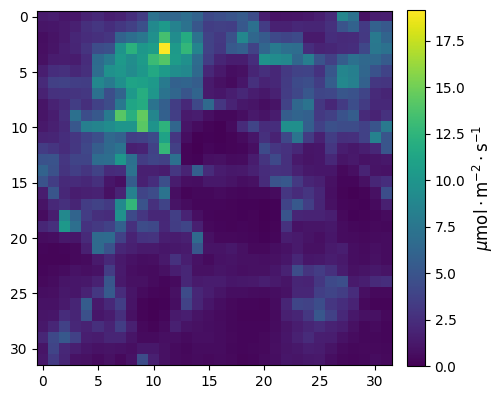

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
img_display = plot_emission_field_tensor(torch.zeros(32, 32), ax=ax, vmax=vmax)

bar = tqdm(total=num_steps, file=sys.stdout)

def update(frame):
    bar.update()
    frame = scale_emission_field_tensor_for_plotting(frames[frame])
    img_display.set_data(frame)
    return [img_display]


ani = FuncAnimation(fig, update, frames=num_steps, blit=False)

ani.save(animation_path, writer="pillow", fps=30)